In [1]:
"""
Model code for:
Interdependent Diffusion: The social contagion of interacting beliefs
James Houghton
October 12, 2019

Written using:
- Python 3.7.1
- NetworkX 2.3
- Pandas 0.24.2
- Scikit-learn 0.20.1

This code is slower than it needs to be, in order to make each operation explicit.

To import this module into another python file or jupyter notebook, call:
    from example_code import *

To run a matched simulation of interdependent and independent diffusion, call:
    result = run()

To run a number of simulations and average their output, call:
    n_sims = 10
    df = pd.concat([run() for i in range(n_sims)])
    result = df.groupby(level=0).aggregate('mean')

"""

import networkx as nx
import numpy as np
import itertools
import pandas as pd
import copy
from sklearn.decomposition import PCA


def susceptible(g, agent, belief):
    """Assess whether an agent is susceptible to a given belief"""
    if 'S' in g.nodes[agent]:  # has exogenous susceptibility defined (independent case)
        return g.nodes[agent]['S'].has_edge(*belief)
    else:  # interdependent case
        try:
            return nx.shortest_path_length(g.nodes[agent]['M'], *belief) <= 2  # current holders are also susceptible
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            return False  # no path exists between the nodes


def adopt(g, agent, belief):
    """Assess whether an agent will adopt a given belief"""
    suscep = susceptible(g, agent, belief)
    exposed = any([belief in g.nodes[nbr]['M'].edges() for nbr in g[agent]])
    return suscep and exposed  # both susceptibility and exposure required to adopt


def measure(g, beliefs, initial_susceptible=None, initial_adopted=None):
    """Take measurements of the state of the system (for creating figures)"""
    res = {}  # dictionary to collect measurements

    # Fig 2A: Susceptible and adopting populations
    # --------------------------------------------
    # build a matrix of who (rows) is susceptible to what beliefs (columns)
    suscep = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
    for agent in g:
        for belief in suscep.columns:
            suscep.at[agent, belief] = susceptible(g, agent, belief)
    res['% susceptible'] = suscep.mean().mean()  # average susceptible fraction across all beliefs

    # build a matrix of who (rows) holds what beliefs (columns)
    adopt = pd.DataFrame(index=g.nodes(), columns=[tuple(b) for b in beliefs])
    for agent in g:
        for belief in adopt.columns:
            adopt.at[agent, belief] = g.nodes[agent]['M'].has_edge(*belief)
    res['% adopted'] = adopt.mean().mean()  # average adopting fraction across all beliefs

    # Fig 2B:correlation between predicted new adoption and actual new adoption
    # -------------------------------------------------------------------------
    if initial_adopted is not None and initial_susceptible is not None:  # t>0
        res['initial prediction correlation'] = np.corrcoef(
            adopt.sum(axis=0) - initial_adopted,
            initial_susceptible - initial_adopted
        )[1, 0]  # select an off-diagonal term
    else:  # first time => establish baseline
        initial_adopted = adopt.sum(axis=0)
        initial_susceptible = suscep.sum(axis=0)
        res['initial prediction correlation'] = np.nan  # measure has no meaning at t0

    # Fig 2C: correlation between a belief and it's most popular neighbor
    # -------------------------------------------------------------------
    adopt_counts = pd.DataFrame()
    adopt_counts['self'] = adopt.sum(axis=0)
    adopt_counts['leading neighbor'] = 0
    for c1 in adopt.columns:
        # search for the leading neighbor's popularity
        leading_value = 0
        for c2 in adopt.columns:
            if len((set(c1) | set(c2))) == 3:  # three nodes total => c1 and c2 are neighbors
                leading_value = max(leading_value, adopt_counts.loc[[c2], 'self'].values[0])
        adopt_counts.at[[c1], 'leading neighbor'] = leading_value
    res['leading neighbor correlation'] = adopt_counts.corr().loc['self', 'leading neighbor']

    # Fig 2D: clustering coefficient of 10% most popular beliefs
    # ----------------------------------------------------------
    # shuffle within sorted value so that when 10% falls within a level of popularity
    # we don't add spurious clustering by selecting sequential beliefs
    adopt_counts['shuffle'] = np.random.rand(len(adopt_counts))
    adopt_counts.sort_values(by=['self', 'shuffle'], inplace=True, ascending=False)
    leaders = adopt_counts.iloc[:int(len(adopt_counts) * 0.1)]  # take leading 10% of beliefs
    popular_graph = nx.from_edgelist(list(leaders.index))  # construct semantic network from leading beliefs
    res['popular belief clustering'] = nx.average_clustering(popular_graph)

    # Fig 3A: similarity btw 5% and 95% most similar pairs
    # ----------------------------------------------------
    n_agents = len(adopt.index)
    corrs = adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
    res['95% similarity'] = np.percentile(corrs, 95)
    res['5% similarity'] = np.percentile(corrs, 5)

    # Fig 3B: PC1 percent variance
    # ----------------------------
    pca = PCA(n_components=1)
    pca.fit(adopt)
    res['PC1 percent of variance'] = pca.explained_variance_ratio_[0] * 100

    return res, initial_susceptible, initial_adopted


def simulate(g, n_steps=10):
    """Conduct a single run of the simulation with a given network"""
    # capture a list of all the beliefs in the population
    beliefs = np.unique([tuple(sorted(belief)) for agent in g for belief in g.nodes[agent]['M'].edges()], axis=0)

    m0, initial_susceptible, initial_adopted = measure(g, beliefs)  # measure initial conditions
    m = [m0]  # array to collect measurements at each time step

    for step in range(n_steps):  # perform the simulation
        for ego in np.random.permutation(g):  # cycle through agents in random order
            for edge in np.random.permutation(beliefs):  # cycle through all possible beliefs in random order
                if adopt(g, ego, edge):  # check whether the selected agent adopts the selected belief
                    g.nodes[ego]['M'].add_edges_from([edge])  # add the belief to the agent's semantic network
        m.append(measure(g, beliefs, initial_susceptible, initial_adopted)[0])  # ignore returned init suscep and adopt

    return pd.DataFrame(m)  # format as pandas DataFrame


def run(n_agents=40, deg=3, n_concepts=25, n_beliefs=25, t_match_susceptibility=0, n_steps=10):
    """Run a matched pair of simulations (inter/independent) from the same initial condition

    Parameters
    ----------
    n_agents: (integer) - Number of agents in the population
    deg: (integer) - How many neighbors each agent has (on average)
    n_concepts: (integer) - How many nodes are in the complete semantic network that beliefs are drawn from
    n_beliefs: (integer) - Exact number of beliefs (semantic net edges) each agent is initialized with
    t_match_susceptibility: (integer) - the model timestep at which the interdependent results will be
                                        must be less than n_steps
    n_steps: (integer) - Number of timesteps in the model
    """

    # Shared Initial Setup
    # --------------------
    # create a random connected social network g0
    connected = False
    while not connected:
        g0 = nx.gnm_random_graph(n=n_agents, m=int(n_agents * deg / 2))
        connected = nx.is_connected(g0)

    # give agents their initial beliefs
    nx.set_node_attributes(
        g0,
        name='M',  # set node attribute 'M' (for 'mind')
        # create a semantic network with a different random set of beliefs
        # for each agent, and assign to nodes in the social network
        values={agent: nx.gnm_random_graph(n_concepts, n_beliefs) for agent in g0}
    )

    # Interdependent simulation
    # -------------------------
    g1 = copy.deepcopy(g0)  # create copy, to preserve initial conditions for other case
    res1 = simulate(g1, n_steps)

    # Independent simulation
    # ----------------------
    g2 = copy.deepcopy(g0)  # copy from original starting conditions

    # calculate the population likelihood of being susceptible to a given (non-held) belief
    p = ((res1.loc[t_match_susceptibility, '% susceptible'] - res1.loc[0, '% adopted']) /
         (1 - res1.loc[0, '% adopted']))

    # choose a set of beliefs for each agent to be susceptible to
    new_sus = {}
    for agent in g2:
        gc = nx.complete_graph(n_concepts)  # potentially susceptible to any belief
        gc.remove_edges_from(g2.nodes[agent]['M'].edges())  # temporarily remove existing beliefs
        # from remainder, randomly select a subset of beliefs to be susceptible to
        edges = list(itertools.compress(
            list(gc.edges()),  # selection candidates
            np.random.binomial(n=1, p=p, size=len(gc.edges())) == 1  # selection mask
        ))
        edges += list(g2.nodes[agent]['M'].edges())  # add susceptibility to existing beliefs
        new_sus[agent] = nx.from_edgelist(edges)  # create networkx graph of susceptibilities

    nx.set_node_attributes(g2, name='S', values=new_sus)  # assign to positions in social network
    res2 = simulate(g2, n_steps)  # perform simulation

    return pd.merge(res1, res2, left_index=True, right_index=True,
                    suffixes=(' (inter)', ' (indep)'))  # format as single pandas DataFrame


In [2]:
# to run a single simulation
result = run()
result

,% susceptible (inter),% adopted (inter),initial prediction correlation (inter),leading neighbor correlation (inter),popular belief clustering (inter),95% similarity (inter),5% similarity (inter),PC1 percent of variance (inter),% susceptible (indep),% adopted (indep),initial prediction correlation (indep),leading neighbor correlation (indep),popular belief clustering (indep),95% similarity (indep),5% similarity (indep),PC1 percent of variance (indep)
0,0.218515,0.085324,NaN,-0.017913,0.127536,0.081642,-0.093284,4.463432,0.22099,0.085324,NaN,-0.017913,0.215942,0.081642,-0.093284,4.463432
1,0.367918,0.149232,0.287149,0.096245,0.139234,0.183839,-0.084029,7.353668,0.22099,0.120478,0.434942,0.023113,0.153968,0.155274,-0.080791,5.803265
2,0.564846,0.315614,0.268912,0.118337,0.291775,0.311622,-0.083707,16.223760,0.22099,0.126109,0.452713,0.057732,0.124242,0.158531,-0.082594,6.000217
3,0.637457,0.466553,0.137033,0.244248,0.067800,0.337434,-0.106178,21.465063,0.22099,0.126365,0.454222,0.057970,0.153968,0.158579,-0.082590,5.980431
4,0.667918,0.561604,0.094906,0.365304,0.224735,0.351677,-0.145386,19.865348,0.22099,0.126365,0.454222,0.057970,0.271212,0.158579,-0.082590,5.980431
5,0.674488,0.598635,0.063982,0.423196,0.328906,0.338448,-0.176212,18.968937,0.22099,0.126365,0.454222,0.057970,0.122222,0.158579,-0.082590,5.980431
6,0.676792,0.604522,0.061402,0.437222,0.168421,0.369555,-0.180511,18.649381,0.22099,0.126365,0.454222,0.057970,0.211111,0.158579,-0.082590,5.980431
7,0.677218,0.606570,0.066799,0.429412,0.131830,0.369555,-0.182406,18.463051,0.22099,0.126365,0.454222,0.057970,0.236667,0.158579,-0.082590,5.980431
8,0.677218,0.606826,0.067666,0.428745,0.227513,0.369555,-0.183146,18.459542,0.22099,0.126365,0.454222,0.057970,0.225397,0.158579,-0.082590,5.980431
9,0.677389,0.606997,0.068151,0.428400,0.443091,0.369555,-0.182240,18.434345,0.22099,0.126365,0.454222,0.057970,0.211111,0.158579,-0.082590,5.980431


## Match independent susceptibility to the initial state of the interdependent case

In [3]:
# to average a number of simulations
n_sims = 10
df = pd.concat([run() for i in range(n_sims)])
result = df.groupby(level=0).aggregate('mean')
result

,% susceptible (inter),% adopted (inter),initial prediction correlation (inter),leading neighbor correlation (inter),popular belief clustering (inter),95% similarity (inter),5% similarity (inter),PC1 percent of variance (inter),% susceptible (indep),% adopted (indep),initial prediction correlation (indep),leading neighbor correlation (indep),popular belief clustering (indep),95% similarity (indep),5% similarity (indep),PC1 percent of variance (indep)
0,0.218607,0.086062,NaN,-0.032422,0.055686,0.085718,-0.094166,4.553980,0.219467,0.086062,NaN,-0.032422,0.069089,0.085718,-0.094166,4.553980
1,0.366441,0.147637,0.297609,0.158944,0.141249,0.190126,-0.090730,7.409281,0.219467,0.121493,0.384905,-0.059203,0.053820,0.147831,-0.089086,5.507351
2,0.548124,0.280867,0.215157,0.304327,0.235869,0.310721,-0.092826,14.463271,0.219467,0.126870,0.436638,-0.040444,0.093242,0.157818,-0.086964,5.701422
3,0.651648,0.447278,0.193852,0.435344,0.423567,0.370723,-0.098445,14.752274,0.219467,0.127722,0.447988,-0.032864,0.070355,0.159513,-0.086753,5.726085
4,0.679108,0.544206,0.182926,0.476993,0.509600,0.387175,-0.121824,13.565223,0.219467,0.127834,0.448639,-0.032231,0.083535,0.160256,-0.086689,5.725521
5,0.685204,0.577423,0.186147,0.497893,0.514814,0.390003,-0.131286,13.236516,0.219467,0.127843,0.448530,-0.032015,0.093244,0.160248,-0.086687,5.723146
6,0.686500,0.588665,0.192009,0.514978,0.602525,0.386556,-0.137649,13.011774,0.219467,0.127843,0.448530,-0.032015,0.070228,0.160248,-0.086687,5.723146
7,0.686827,0.592344,0.197594,0.523848,0.550338,0.387564,-0.139682,13.020091,0.219467,0.127843,0.448530,-0.032015,0.085141,0.160248,-0.086687,5.723146
8,0.686870,0.593229,0.198331,0.525464,0.537073,0.388667,-0.139881,13.036066,0.219467,0.127843,0.448530,-0.032015,0.070100,0.160248,-0.086687,5.723146
9,0.686878,0.593487,0.199000,0.525906,0.523956,0.387948,-0.140051,13.040704,0.219467,0.127843,0.448530,-0.032015,0.083975,0.160248,-0.086687,5.723146


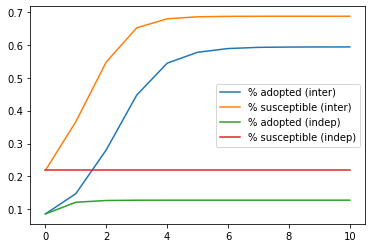

In [4]:
result[['% adopted (inter)', '% susceptible (inter)', '% adopted (indep)', '% susceptible (indep)']].plot();

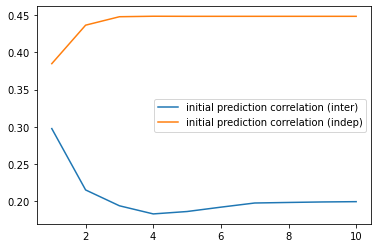

In [5]:
result[['initial prediction correlation (inter)', 'initial prediction correlation (indep)']].plot();

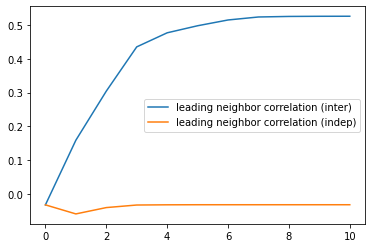

In [6]:
result[['leading neighbor correlation (inter)', 'leading neighbor correlation (indep)']].plot();

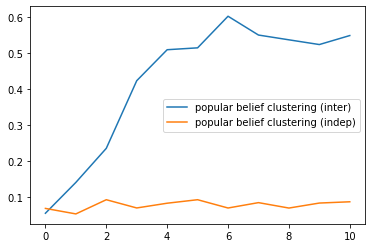

In [7]:
result[['popular belief clustering (inter)', 'popular belief clustering (indep)']].plot();

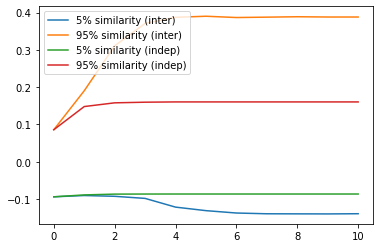

In [8]:
result[['5% similarity (inter)', '95% similarity (inter)', 
        '5% similarity (indep)', '95% similarity (indep)']].plot();

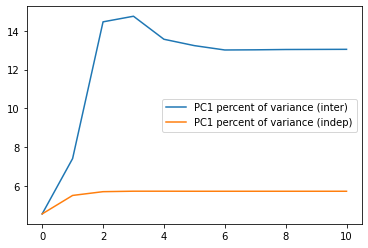

In [9]:
result[['PC1 percent of variance (inter)', 'PC1 percent of variance (indep)']].plot()

## Match susceptibility to the final state of the interdependent case

In [10]:
# to average a number of simulations
n_sims = 10
df = pd.concat([run(t_match_susceptibility=9) for i in range(n_sims)])
result = df.groupby(level=0).aggregate('mean')
result

,% susceptible (inter),% adopted (inter),initial prediction correlation (inter),leading neighbor correlation (inter),popular belief clustering (inter),95% similarity (inter),5% similarity (inter),PC1 percent of variance (inter),% susceptible (indep),% adopted (indep),initial prediction correlation (indep),leading neighbor correlation (indep),popular belief clustering (indep),95% similarity (indep),5% similarity (indep),PC1 percent of variance (indep)
0,0.221175,0.086307,NaN,-0.026631,0.047548,0.094013,-0.094461,4.529980,0.676324,0.086307,NaN,-0.026631,0.072944,0.094013,-0.094461,4.529980
1,0.374283,0.151896,0.294173,0.138147,0.119645,0.195596,-0.091985,7.446405,0.676324,0.319554,0.148054,-0.007131,0.072984,0.349869,-0.081893,12.386494
2,0.560852,0.293697,0.252874,0.287523,0.239905,0.320801,-0.094818,13.247667,0.676324,0.482281,0.402211,0.004990,0.102745,0.311165,-0.055343,10.382746
3,0.641140,0.453877,0.212374,0.392417,0.360866,0.360164,-0.102446,15.628629,0.676324,0.542763,0.545807,-0.019869,0.088522,0.272769,-0.043807,8.379609
4,0.667794,0.537963,0.200389,0.442403,0.430075,0.374474,-0.121584,14.032030,0.676324,0.560199,0.595130,-0.021704,0.091657,0.252431,-0.040845,7.951087
5,0.673071,0.567502,0.201432,0.471454,0.505190,0.375425,-0.135725,13.301550,0.676324,0.565942,0.613849,-0.013014,0.087523,0.245689,-0.039574,7.800083
6,0.674900,0.577465,0.199646,0.483564,0.534792,0.382531,-0.140660,13.164831,0.676324,0.567805,0.618594,-0.011574,0.088952,0.243306,-0.040212,7.756272
7,0.675107,0.580294,0.199069,0.487433,0.533277,0.381962,-0.141589,13.168822,0.676324,0.568260,0.620201,-0.011488,0.088612,0.242446,-0.040234,7.744779
8,0.675541,0.581363,0.198378,0.488807,0.511893,0.381278,-0.142239,13.147248,0.676324,0.568363,0.620604,-0.011543,0.099464,0.242641,-0.040230,7.740712
9,0.675636,0.581796,0.198809,0.489169,0.533450,0.381393,-0.142280,13.135577,0.676324,0.568414,0.620745,-0.011556,0.076521,0.242641,-0.040230,7.739184


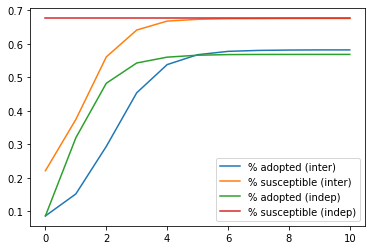

In [11]:
result[['% adopted (inter)', '% susceptible (inter)', '% adopted (indep)', '% susceptible (indep)']].plot();

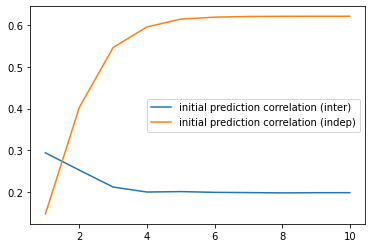

In [12]:
result[['initial prediction correlation (inter)', 'initial prediction correlation (indep)']].plot();

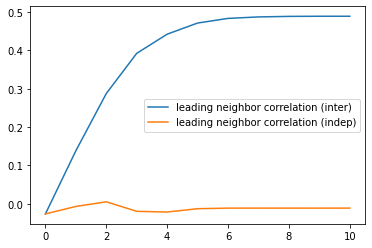

In [13]:
result[['leading neighbor correlation (inter)', 'leading neighbor correlation (indep)']].plot();

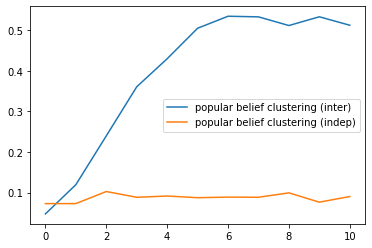

In [14]:
result[['popular belief clustering (inter)', 'popular belief clustering (indep)']].plot();

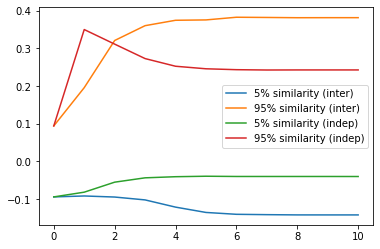

In [15]:
result[['5% similarity (inter)', '95% similarity (inter)', 
        '5% similarity (indep)', '95% similarity (indep)']].plot();

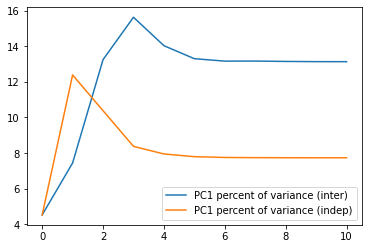

In [16]:
result[['PC1 percent of variance (inter)', 'PC1 percent of variance (indep)']].plot()